<a href="https://colab.research.google.com/github/UW-ERSL/MaTruss/blob/main/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import torch
import os, sys
import time
import matplotlib.pyplot as plt
import matplotlib
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon
sys.path.append(os.path.realpath('./src/'))
from utilFuncs import to_np, to_torch
from materialEncoder import MaterialEncoder


import seaborn as sns
import scipy as sp

### Read material properties from the database. The properties are then scaled to facilitate training

In [2]:
def preprocessData():
  df = pd.read_excel('./data/solidworksMaterialDatabase_SUBSET.xlsx')
  dataIdentifier = {'name': df[df.columns[0]], 'className':df[df.columns[1]], 'classID':df[df.columns[2]]} # name of the material and type
  trainInfo = np.log10(df[df.columns[3:]].to_numpy())
  dataScaleMax = torch.tensor(np.max(trainInfo, axis = 0))
  dataScaleMin = torch.tensor(np.min(trainInfo, axis = 0))
  normalizedData = (torch.tensor(trainInfo) - dataScaleMin)/(dataScaleMax - dataScaleMin)
  trainingData = torch.tensor(normalizedData).float()
  dataInfo = {'youngsModulus':{'idx':0,'scaleMin':dataScaleMin[0], 'scaleMax':dataScaleMax[0]},\
              'costPerKg':{'idx':1,'scaleMin':dataScaleMin[1], 'scaleMax':dataScaleMax[1]},\
              'massDensity':{'idx':2,'scaleMin':dataScaleMin[2], 'scaleMax':dataScaleMax[2]},\
              'yieldStrength':{'idx':3,'scaleMin':dataScaleMin[3], 'scaleMax':dataScaleMax[3]}}
  return trainingData, dataInfo, dataIdentifier, trainInfo
trainingData, dataInfo, dataIdentifier, trainInfo = preprocessData()
numMaterialsInTrainingData, numFeatures = trainingData.shape

C:\Users\luisy\AppData\Local\Temp\ipykernel_11632\3843651503.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainingData = torch.tensor(normalizedData).float()


### we now train the VAE 

In [3]:
latentDim, hiddenDim = 2, 250
numEpochs = 50000
klFactor = 5e-5
learningRate = 2e-3
savedNet = './data/vaeNet.nt'
vaeSettings = {'encoder':{'inputDim':numFeatures, 'hiddenDim':hiddenDim,\
                                          'latentDim':latentDim},\
               'decoder':{'latentDim':latentDim, 'hiddenDim':hiddenDim,\
                                          'outputDim':numFeatures}}
materialEncoder = MaterialEncoder(trainingData, dataInfo, dataIdentifier, vaeSettings)

start = time.perf_counter()
convgHistory = materialEncoder.trainAutoencoder(numEpochs, klFactor, savedNet, learningRate)
print('training time : {:.2F}'.format(time.perf_counter() - start))

Iter 0 reconLoss 3.96E+01 klLoss 7.27E-03 loss 3.96E+01
Iter 500 reconLoss 9.28E-02 klLoss 4.32E-02 loss 1.36E-01
Iter 1000 reconLoss 6.76E-02 klLoss 4.01E-02 loss 1.08E-01
Iter 1500 reconLoss 5.14E-02 klLoss 3.74E-02 loss 8.88E-02
Iter 2000 reconLoss 4.41E-02 klLoss 3.58E-02 loss 7.99E-02
Iter 2500 reconLoss 3.57E-02 klLoss 3.50E-02 loss 7.07E-02
Iter 3000 reconLoss 3.40E-02 klLoss 3.46E-02 loss 6.86E-02
Iter 3500 reconLoss 2.96E-02 klLoss 3.42E-02 loss 6.38E-02
Iter 4000 reconLoss 3.06E-02 klLoss 3.38E-02 loss 6.44E-02
Iter 4500 reconLoss 2.64E-02 klLoss 3.33E-02 loss 5.97E-02
Iter 5000 reconLoss 3.27E-02 klLoss 3.31E-02 loss 6.58E-02
Iter 5500 reconLoss 2.16E-02 klLoss 3.29E-02 loss 5.44E-02
Iter 6000 reconLoss 1.95E-02 klLoss 3.26E-02 loss 5.21E-02
Iter 6500 reconLoss 1.97E-02 klLoss 3.25E-02 loss 5.22E-02
Iter 7000 reconLoss 2.06E-02 klLoss 3.20E-02 loss 5.25E-02
Iter 7500 reconLoss 1.70E-02 klLoss 3.19E-02 loss 4.89E-02
Iter 8000 reconLoss 1.91E-02 klLoss 3.18E-02 loss 5.09E-02
I

In [4]:
plt.close('all')

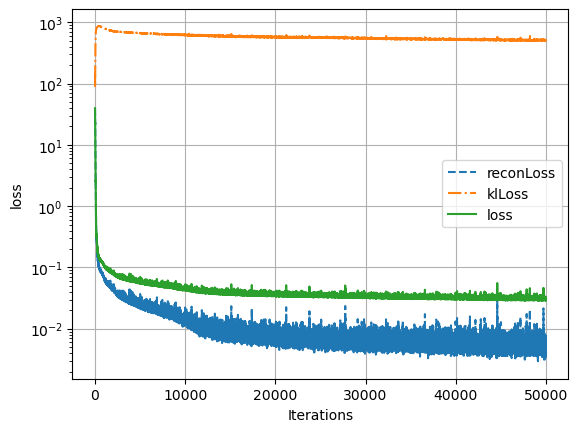

In [5]:
# Moving average convergence plots
def plotConvergence(convg):
  plt.figure();
  strokes = ['--', '-.', '-', ':']
  for ctr, key in enumerate(convg):
    
    y = np.array(convg[key])
    y_mvavg = np.convolve(y, np.ones(1), 'valid') / 1.
    plt.semilogy(y_mvavg, strokes[ctr], label = str(key))
    plt.xlabel('Iterations')
    plt.ylabel(str(key))
    plt.grid('True')
    plt.legend()
    plt.savefig('./figures/convergence.pdf')

plotConvergence(convgHistory)

In [6]:
# Analyze the reconstruction error
matidxs = np.array([2,11,19,45,53,68,22,4,70]).astype(int)-2
props = ['youngsModulus','costPerKg','massDensity','yieldStrength']
print([dataIdentifier['name'][i] for i in matidxs])
print('\t \t ------TRUE DATA----------')
print('material name', end = '\t')
for p in props:
    print(p, end = '\t')
for i in matidxs:
  print(f"\n {dataIdentifier['name'][i]} \t ", end = '')
  for p in props:
    idx = materialEncoder.dataInfo[p]['idx']
    print('\t {:.2E}'.format(10.**trainInfo[i,idx]),end='')

def unnormalize(val, minval ,maxval):
  return 10.**(minval + (maxval-minval)*val)
def decodeAll():
  vae = materialEncoder.vaeNet
  decoded = vae.decoder(vae.encoder.z)
  matProp = {'youngsModulus':None,'costPerKg':None,'massDensity':None,'yieldStrength':None}
  for k in props:
    idx = materialEncoder.dataInfo[k]['idx']
    scaleMax = materialEncoder.dataInfo[k]['scaleMax']
    scaleMin = materialEncoder.dataInfo[k]['scaleMin']
    matProp[k] = unnormalize(decoded[:,idx], scaleMin ,scaleMax)
  return matProp

matProp = decodeAll()
print('\n \n \t \t ------RECONSTRUCTED DATA----------') 
print('material name', end = '\t')
for p in props:
    print(p, end = '\t')
  
for i in matidxs:
  print(f"\n {dataIdentifier['name'][i]} \t ", end = '')
  for p in props:
    print('\t {:.2E}'.format(matProp[p][i]), end='')

merr = -1000000000.
maxError = {'youngsModulus':merr,'costPerKg':merr,'massDensity':merr,'yieldStrength':merr}
print('\n \n \t \t ------RECON ERROR (%)----------') 
print('material name', end = '\t')
for p in props:
    print(p, end = '\t')
for i in range(trainInfo.shape[0]):
  if(i in matidxs): #
    print(f"\n {dataIdentifier['name'][i]} \t ", end = '')
  for p in props:
    idx = materialEncoder.dataInfo[p]['idx']
    trueData = 10**trainInfo[i,idx]
    reconData = matProp[p][i]
    err = torch.abs(100.*(trueData - reconData)/trueData)
    if(err > maxError[p]):
      maxError[p] = err
    if(i in matidxs):
      print('\t {:.1F}'.format(err), end='')
      
print('\n max Error \t ', end = '')
for p in props:
  print('\t {:.1F}'.format(maxError[p]), end='')

['A286 Iron', 'AISI 4130 norm', '1060-H14', '3003-O', '5454-H112', 'AA356.0-F', 1345, 'Ti-8Al-1Mo-1V', 'Ti 35A']
	 	 ------TRUE DATA----------
material name	youngsModulus	costPerKg	massDensity	yieldStrength	
 A286 Iron 	 	 2.01E+11	 5.18E+00	 7.92E+03	 6.20E+08
 AISI 4130 norm 	 	 2.05E+11	 5.15E-01	 7.85E+03	 7.31E+08
 1060-H14 	 	 6.90E+10	 2.20E+00	 2.71E+03	 9.50E+07
 3003-O 	 	 6.90E+10	 2.18E+00	 2.73E+03	 1.10E+08
 5454-H112 	 	 7.00E+10	 2.24E+00	 2.69E+03	 2.50E+08
 AA356.0-F 	 	 7.24E+10	 2.24E+00	 2.68E+03	 1.45E+08
 1345 	 	 6.90E+10	 2.19E+00	 2.70E+03	 8.27E+07
 Ti-8Al-1Mo-1V 	 	 1.20E+11	 1.12E+01	 4.37E+03	 9.37E+08
 Ti 35A 	 	 1.05E+11	 1.19E+01	 4.51E+03	 3.45E+08
 
 	 	 ------RECONSTRUCTED DATA----------
material name	youngsModulus	costPerKg	massDensity	yieldStrength	
 A286 Iron 	 	 2.01E+11	 5.11E+00	 7.93E+03	 6.42E+08
 AISI 4130 norm 	 	 2.05E+11	 5.23E-01	 7.85E+03	 7.35E+08
 1060-H14 	 	 6.92E+10	 2.19E+00	 2.71E+03	 9.41E+07
 3003-O 	 	 6.91E+10	 2.19E+00	 2.71

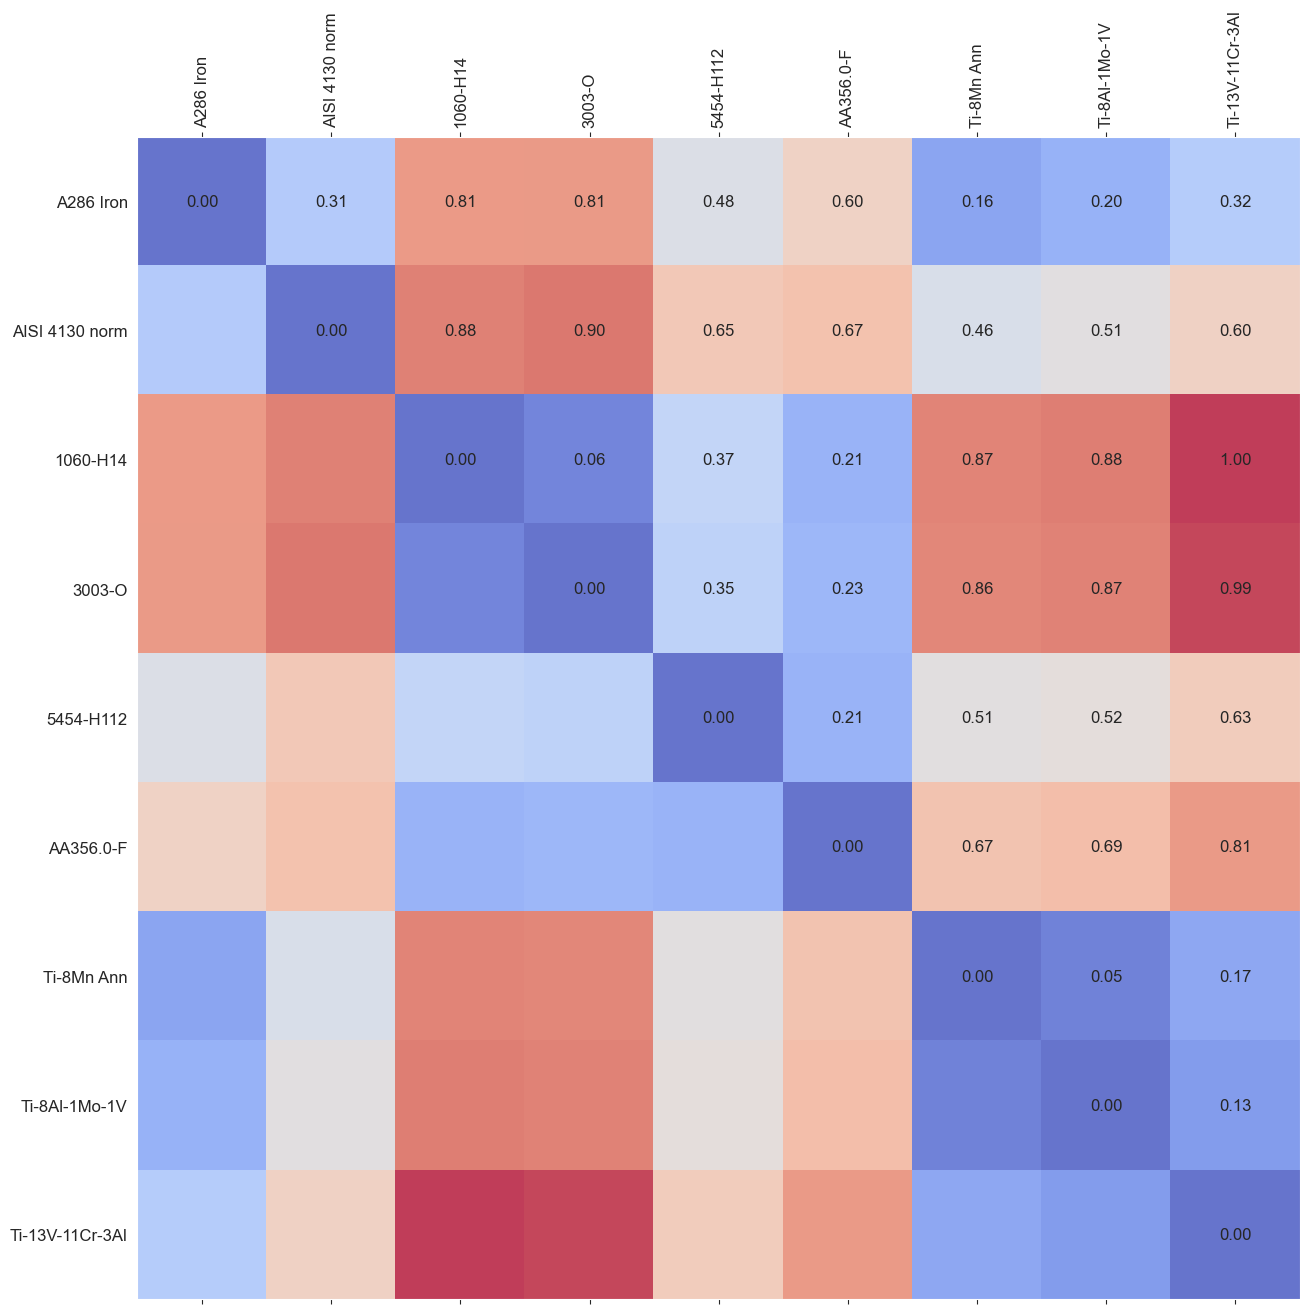

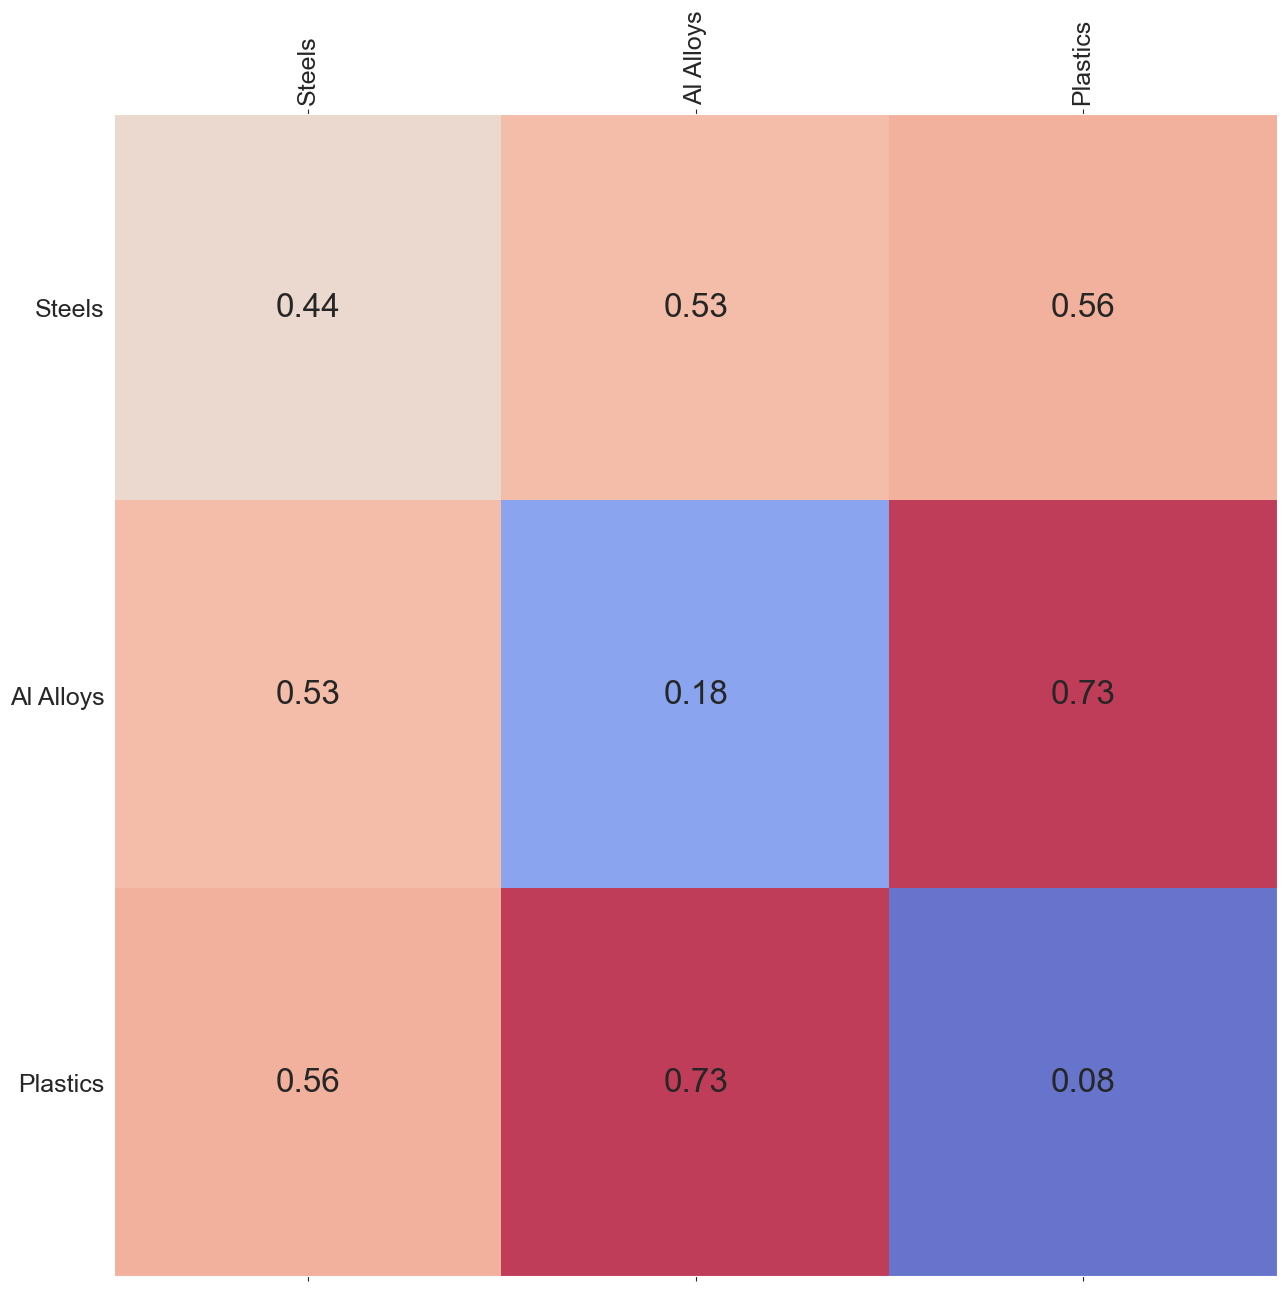

In [7]:
# distance matrix between a select candidate of materials
def drawDistanceMatrix():
  matidxs = np.array([2,11,19,45,53,68,73,4,77]).astype(int)-2 # the rows of mats to consider in the db
  matidxs = np.array([2,11,19,45,53,68,71,4,72]).astype(int)-2 # the rows of mats to consider in the db
  distMatrix = np.zeros((len(matidxs),)*2)
  sns.set_style("dark")
  vae = materialEncoder.vaeNet
  z_np = to_np(vae.encoder.z)
  for rw in range(len(matidxs)):
    for col in range(rw, len(matidxs)):
      mx, my = matidxs[rw], matidxs[col]
      distMatrix[rw,col] = np.linalg.norm(z_np[mx,:] - z_np[my,:])
      distMatrix[col,rw] = distMatrix[rw,col]
  maxval = np.max(distMatrix)

  distMatrix = distMatrix/maxval

  matplotlib.rcParams['figure.figsize'] = (15, 15)
  plt.matshow(distMatrix,cmap="coolwarm", alpha = 0.75)

  ax = plt.gca()

  # Set the plot labels
  xlabels = [dataIdentifier['name'][i] for i in matidxs]
  ax.set_xticks(range(len(matidxs)))
  ax.set_xticklabels(xlabels, rotation = 90, size = 12)
  ax.set_yticks(range(len(matidxs)))
  ax.set_yticklabels(xlabels, size = 12)
  plt.grid(which='minor',c='indigo', ls='-', lw='5.8')
  

  #Add text to the plot showing the values at that point
  for i in range(len(matidxs)):
      for j in range(i,len(matidxs)):
          pltText = '{:.2F}'.format(distMatrix[i,j])
          plt.text(j,i, pltText, horizontalalignment='center', \
                     verticalalignment='center', size = 12)
  plt.savefig('./figures/distanceMatrix.pdf',bbox_inches='tight', dpi = 200)
  plt.show()
  
  avgMatrix = np.zeros((3,3))
  for i in range(3):
    for j in range(3):
      avgMatrix[i,j] = np.mean(distMatrix[3*i:3*(i+1), 3*j:3*(j+1)])
  
  
  
  plt.matshow(avgMatrix,cmap="coolwarm", alpha = 0.75)
  ax = plt.gca()
  for i in range(3):
    for j in range(3):
        pltText = '{:.2F}'.format(avgMatrix[i,j])
        plt.text(j,i, pltText, horizontalalignment='center', \
                   verticalalignment='center', size = 24)
  xlabels = ['Steels', 'Al Alloys', 'Plastics']
  ax.set_xticks(range(3))
  ax.set_xticklabels(xlabels, rotation = 90, size = 18)
  ax.set_yticks(range(3))
  ax.set_yticklabels(xlabels, size = 18)
  plt.savefig('./figures/averageDistanceMatrix.pdf',bbox_inches='tight')
drawDistanceMatrix()


(<Figure size 1500x1500 with 1 Axes>,
 <AxesSubplot:xlabel='$z_0$', ylabel='$z_1$'>)

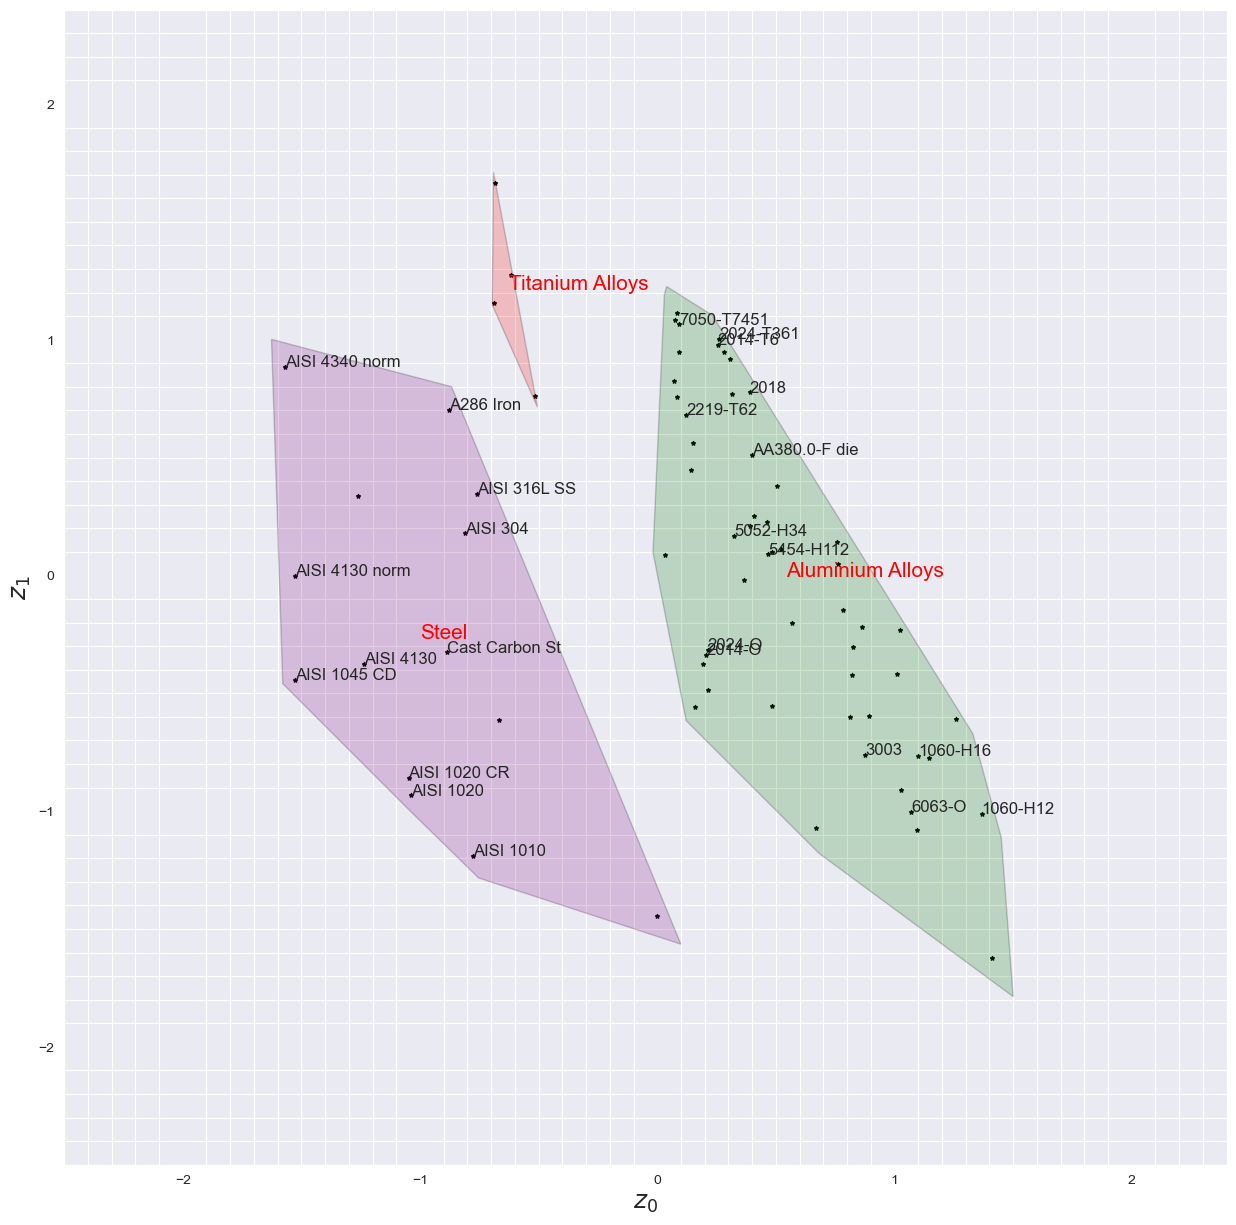

In [8]:
# The latent field
def plotLatent(ltnt1, ltnt2, plotHull, annotateHead, saveFileName):
    clrs = ['purple', 'green', 'red',]
    colorcol = dataIdentifier['classID']
    ptLabel = dataIdentifier['name']
    autoencoder = materialEncoder.vaeNet
    z = autoencoder.encoder.z.to('cpu').detach().numpy()
    fig, ax = plt.subplots()
    matidxs = np.array([13,14,15,48,18,10,9,8,28,20,30,69,27,37,\
                        5,6,73,77,78,85,91,88,75,80,82,83]).astype(int)-2
    matidxs = np.array([13,14,15,48,18,10,9,8,28,20,30,69,27,37,\
                        5,6,7,2,58,25,11,28,65,40,32,53]).astype(int)-2
    for i in range(np.max(colorcol)+1): 
      zMat = np.vstack((z[colorcol == i,ltnt1], z[colorcol == i,ltnt2])).T
      ax.scatter(zMat[:, 0], zMat[:, 1], marker='*', c = 'black', s = 8)#clrs[i]

      if(plotHull):
        hull = ConvexHull(zMat)
        cent = np.mean(zMat, 0)
        pts = []
        for pt in zMat[hull.simplices]:
            pts.append(pt[0].tolist())
            pts.append(pt[1].tolist())
  
        pts.sort(key=lambda p: np.arctan2(p[1] - cent[1],
                                        p[0] - cent[0]))
        pts = pts[0::2]  # Deleting duplicates
        pts.insert(len(pts), pts[0])
        poly = Polygon(1.1*(np.array(pts)- cent) + cent,
                       facecolor= clrs[i], alpha=0.2, edgecolor = 'black') #'black'
        poly.set_capstyle('round')
        plt.gca().add_patch(poly)
        ax.annotate(dataIdentifier['className'][i], (cent[0], cent[1]), size = 15, c = 'red')
    for i, txt in enumerate(ptLabel):
      if(annotateHead == False or ( annotateHead == True and  i in matidxs)):
        
        # continue
        ax.annotate(txt, (z[i,ltnt1], z[i,ltnt2]), size = 12)

    ticks = [-2.5, -2, -1.5, -1., -0.5, 0., 0.5, 1., 1.5]

    plt.xlabel('$z_0$'.format(ltnt1), size = 18)
    plt.ylabel('$z_1$'.format(ltnt2), size = 18)
    minor_ticks = np.arange(-2.5, 2.5, 0.1)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(minor_ticks, minor=True)
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.grid(which='minor')
    plt.savefig(saveFileName)
    
    return fig, ax
  
plotLatent(0, 1, plotHull = True, annotateHead = True, saveFileName = './figures/latent.pdf')

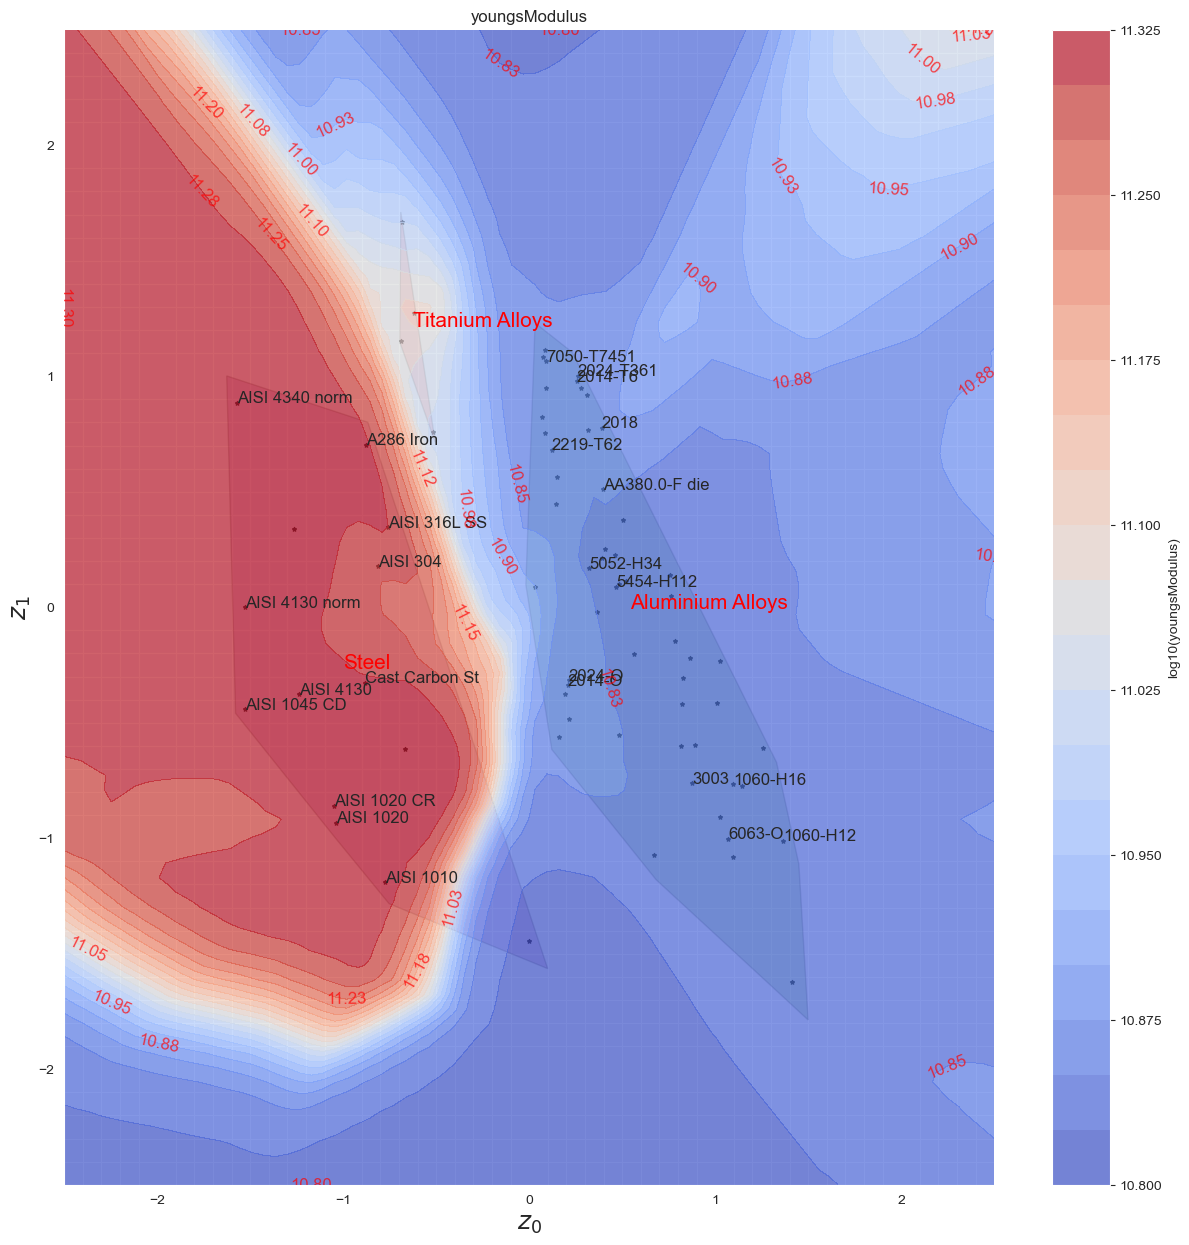

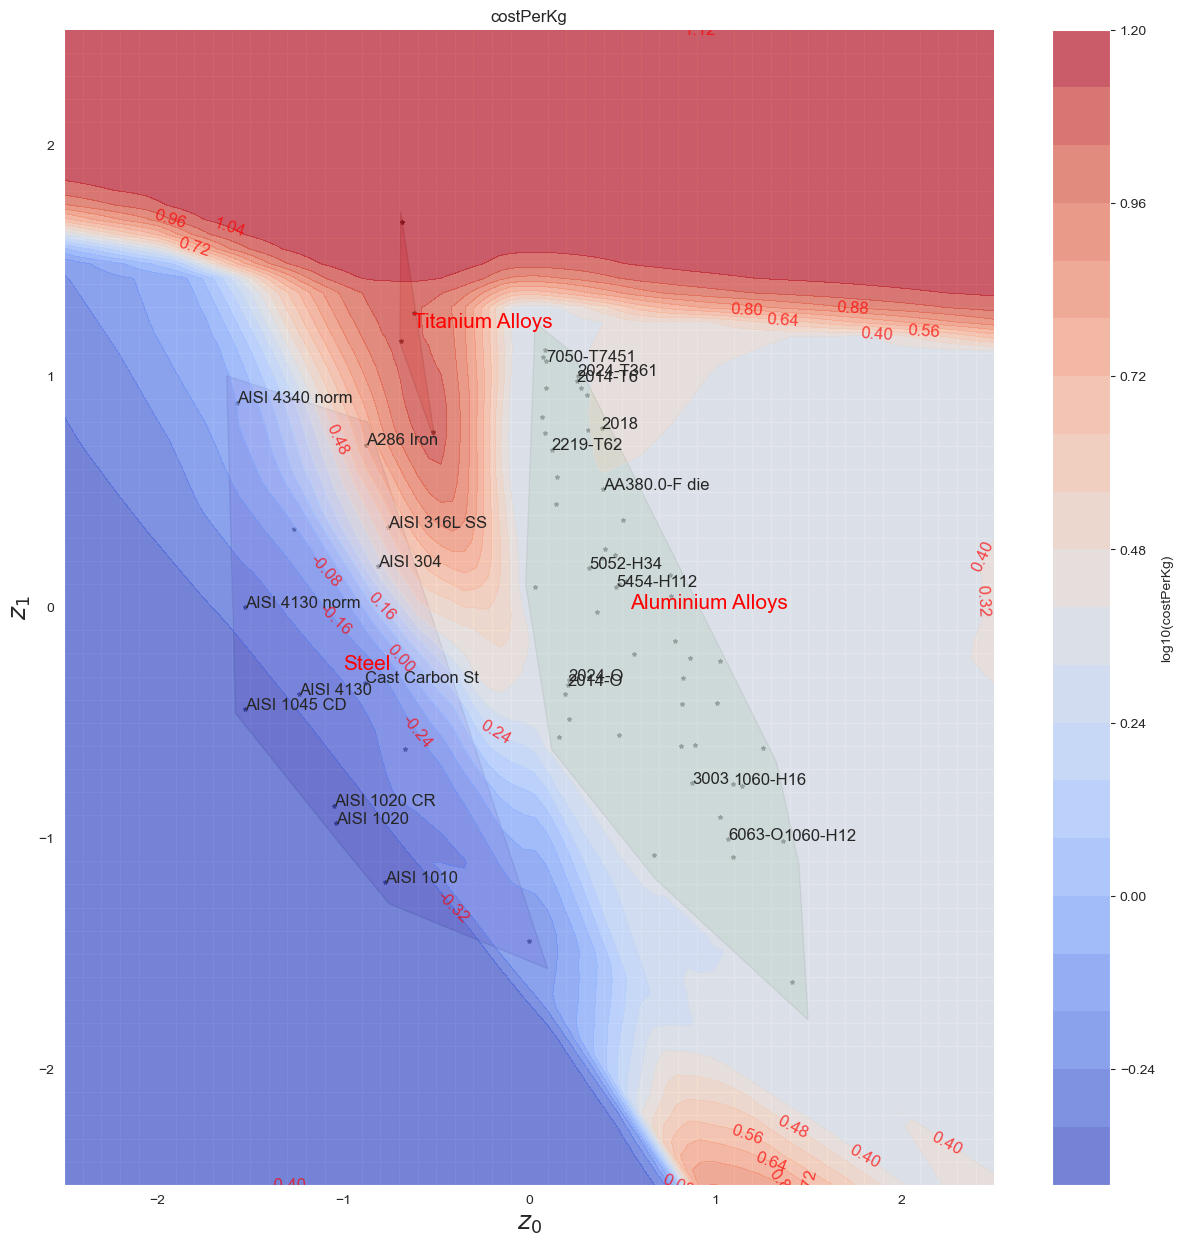

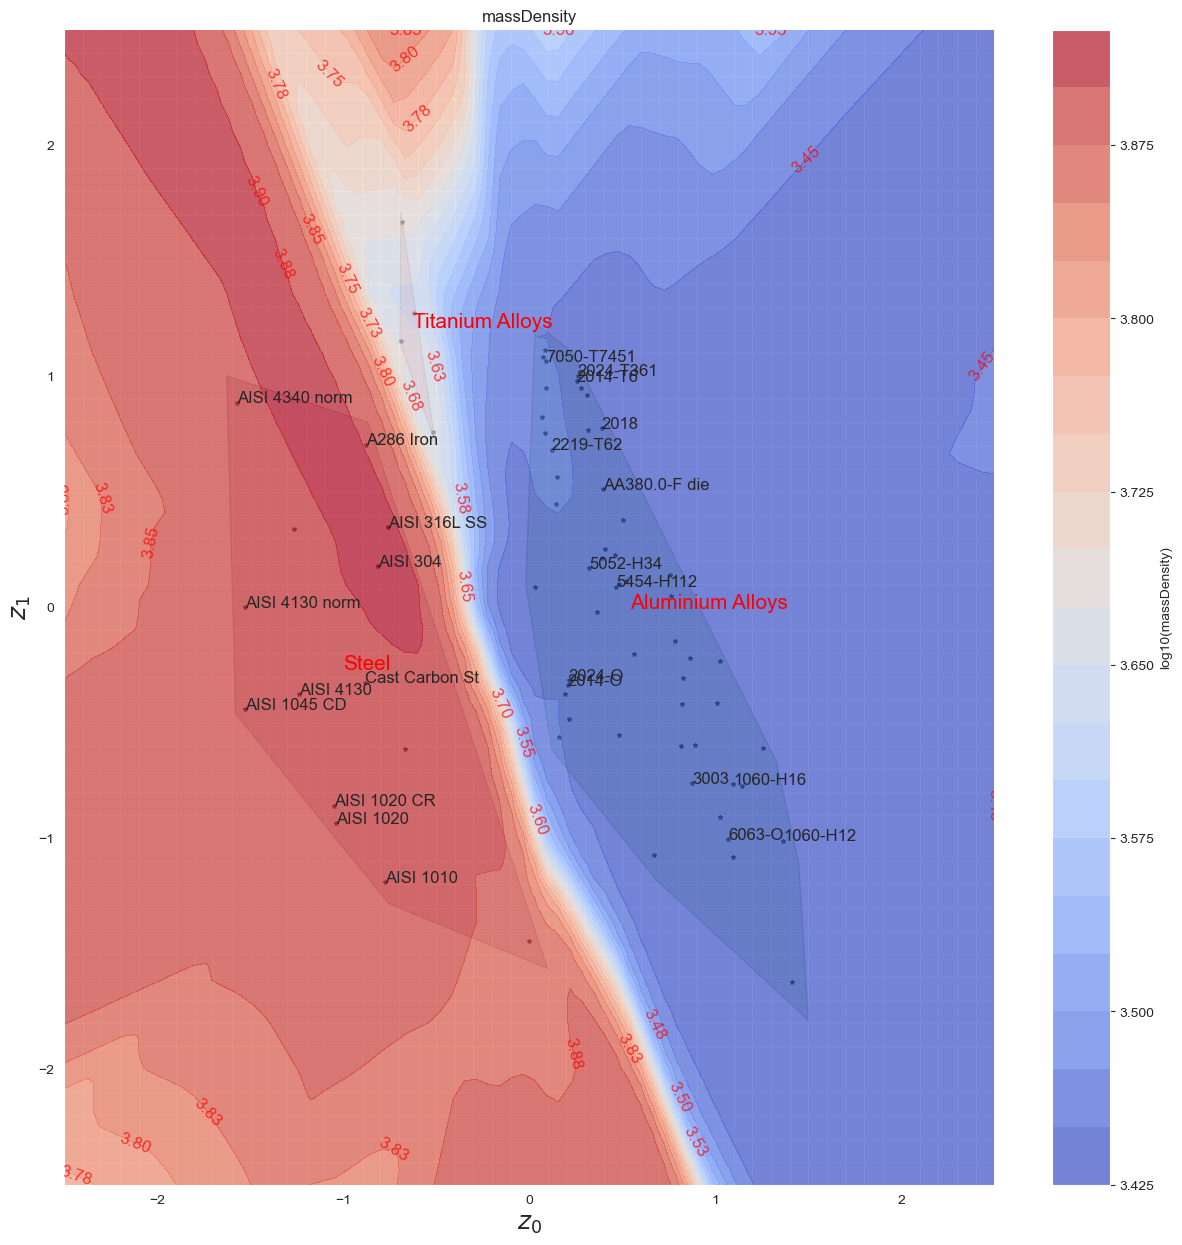

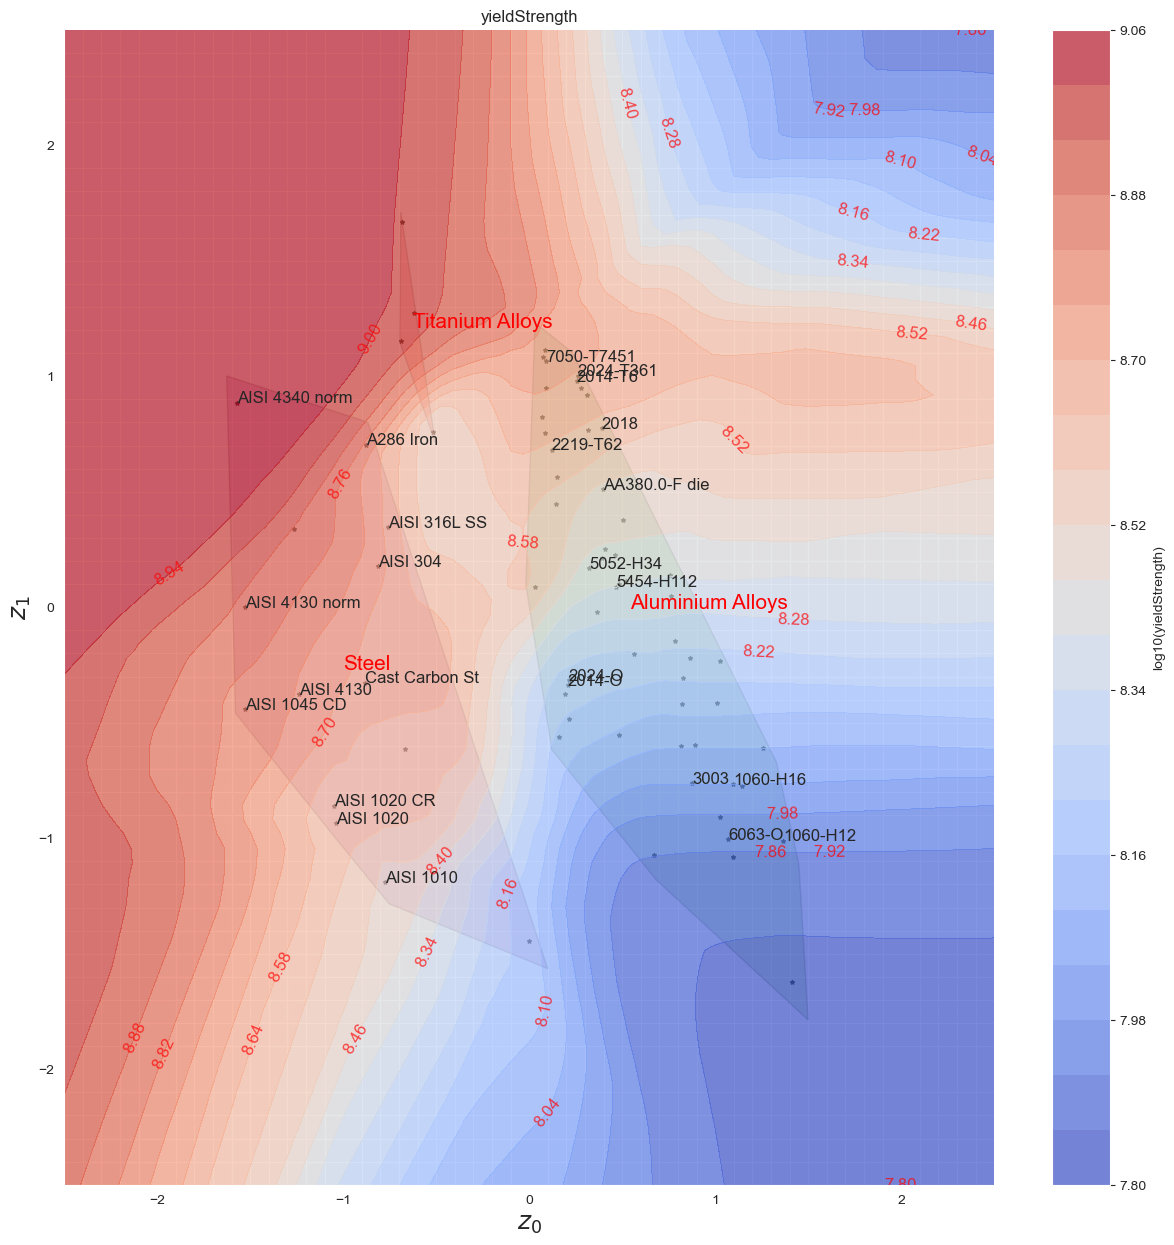

In [9]:
def plotLatentWithProperty(ltnt1 = 0, ltnt2 = 1):
  n = 80
  zmin, zmax = -2.5,2.5
  X,Y = np.meshgrid(np.linspace(zmin, zmax, n), np.linspace(zmin, zmax, n))
  Z = torch.zeros((n**2, vaeSettings['encoder']['latentDim']))
  Z[:,ltnt1], Z[:,ltnt2] = to_torch(X.reshape(-1)), to_torch(Y.reshape(-1))

  vae = materialEncoder.vaeNet
  trainData_z_np = to_np(vae.encoder.z)
  decoded = vae.decoder(Z)

  #-------------------------------------------#
  props = ['youngsModulus','costPerKg','massDensity','yieldStrength']
  for p in props:
    idx = materialEncoder.dataInfo[p]['idx']
    scaleMax = materialEncoder.dataInfo[p]['scaleMax']
    scaleMin = materialEncoder.dataInfo[p]['scaleMin']

    matPropVal = 10.**(scaleMin + decoded[:,idx]*(scaleMax - scaleMin))

    fig, ax = plotLatent(ltnt1 = ltnt1, ltnt2 = ltnt2, plotHull = True,  annotateHead = True,\
                                       saveFileName = './figures/swrksLatent.pdf')
    surf = ax.contourf(X, Y, np.log10(to_np(matPropVal).reshape((n,n))), levels = 20, cmap='coolwarm', alpha = 0.7)
    plt.clabel(surf, inline=False, fontsize=12, fmt ='%0.2F', colors = 'red')
    ax.set_xlabel('$z_0$')
    ax.set_ylabel('$z_1$')
    ax.set_title(p)
    cbar = plt.colorbar(surf)
    cbar.set_label('log10({:s})'.format(str(p)))
    plt.savefig('./figures/{:s}_latentField.pdf'.format(p), dpi=200, bbox_inches='tight')

  #-------------------------------------------#
  
plotLatentWithProperty()

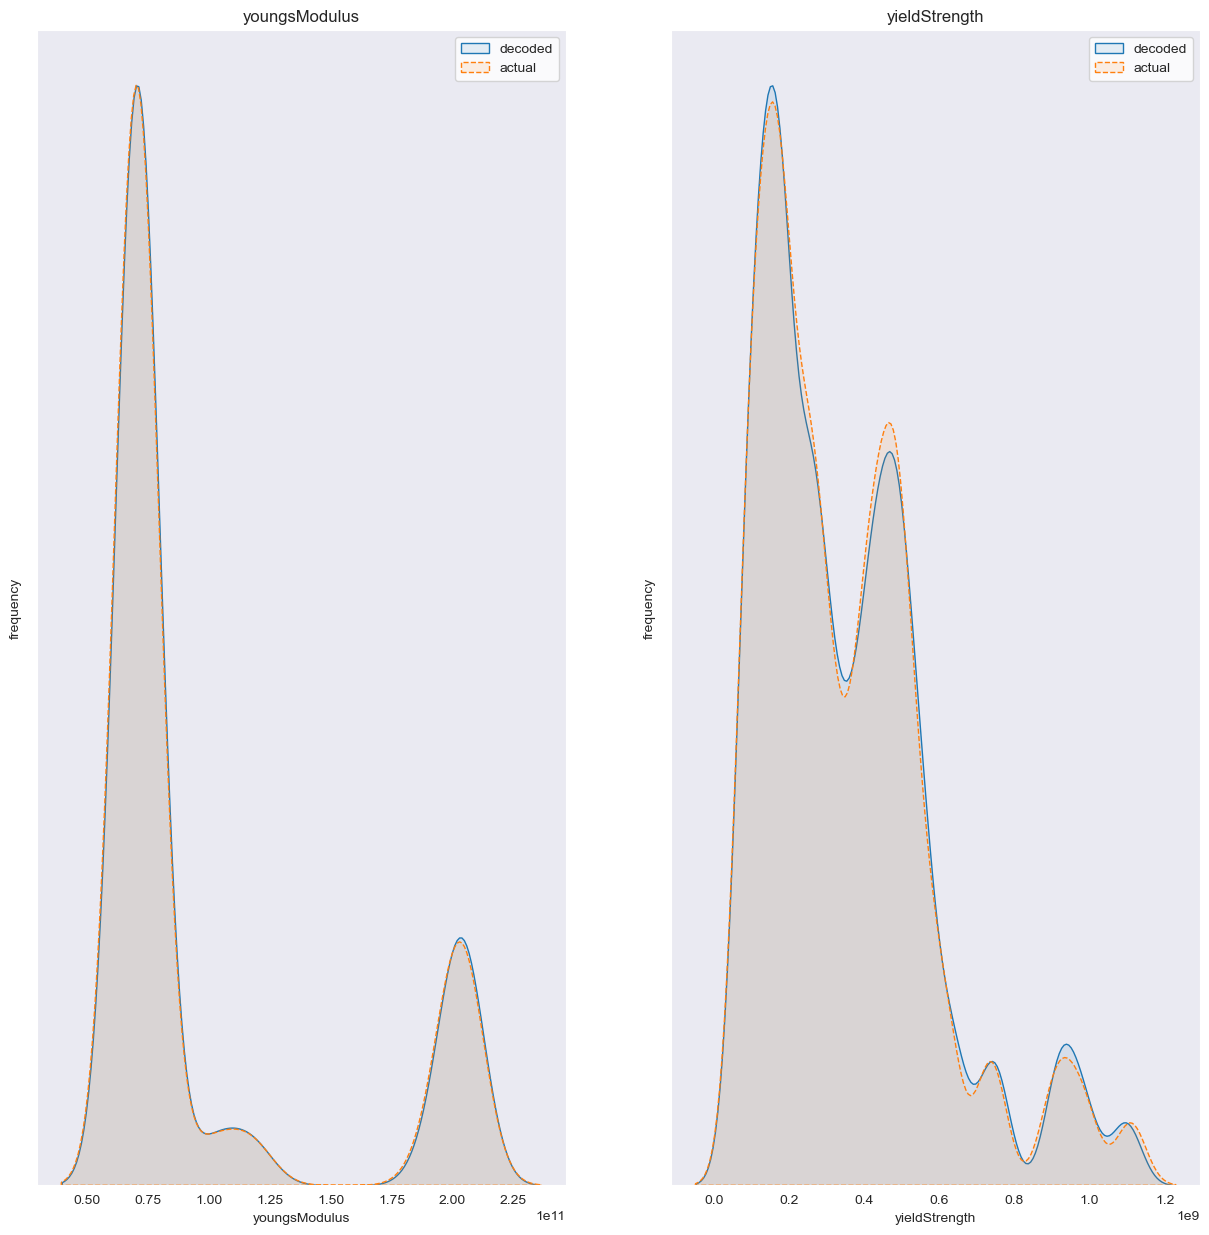

In [10]:
def plotTrueAndReconstructedDistribution():

  vae = materialEncoder.vaeNet
  trainData_z_np = to_np(vae.encoder.z)
  decodedVals = vae.decoder(vae.encoder.z)
  
  bw = 0.405
  fig, ax = plt.subplots(1,2)
  #-------------------------------------------#
  props = ['youngsModulus','costPerKg','massDensity','yieldStrength']
  props = ['youngsModulus','yieldStrength']
  for ctr, p in enumerate(props):
    idx = materialEncoder.dataInfo[p]['idx']
    scaleMax = materialEncoder.dataInfo[p]['scaleMax']
    scaleMin = materialEncoder.dataInfo[p]['scaleMin']

    matVal_decoded = 10.**(scaleMin + decodedVals[:,idx]*(scaleMax - scaleMin))
    matVal_data = 10.**(scaleMin + trainingData[:,idx]*(scaleMax - scaleMin))

    sns.set_style('whitegrid')
    plt.subplot(1,2,ctr+1)
    f = sns.kdeplot(to_np(matVal_decoded), bw_adjust=bw, fill = True, alpha = 0.1, label='decoded')
    f = sns.kdeplot(to_np(matVal_data), bw_adjust=bw,  fill = True, alpha = 0.1, linestyle="--", label='actual')
    f.set(xlabel = p, ylabel = 'frequency',yticklabels=[])
    plt.legend()
    plt.axis('auto')
    plt.title(p)
  
  plt.savefig('./figures/trueAndReconstructedDistribution.pdf'.format(p), dpi=200, bbox_inches='tight')

plotTrueAndReconstructedDistribution()  

C:\Users\luisy\AppData\Local\Temp\ipykernel_11632\1227467745.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z = torch.tensor(Z, requires_grad = True)


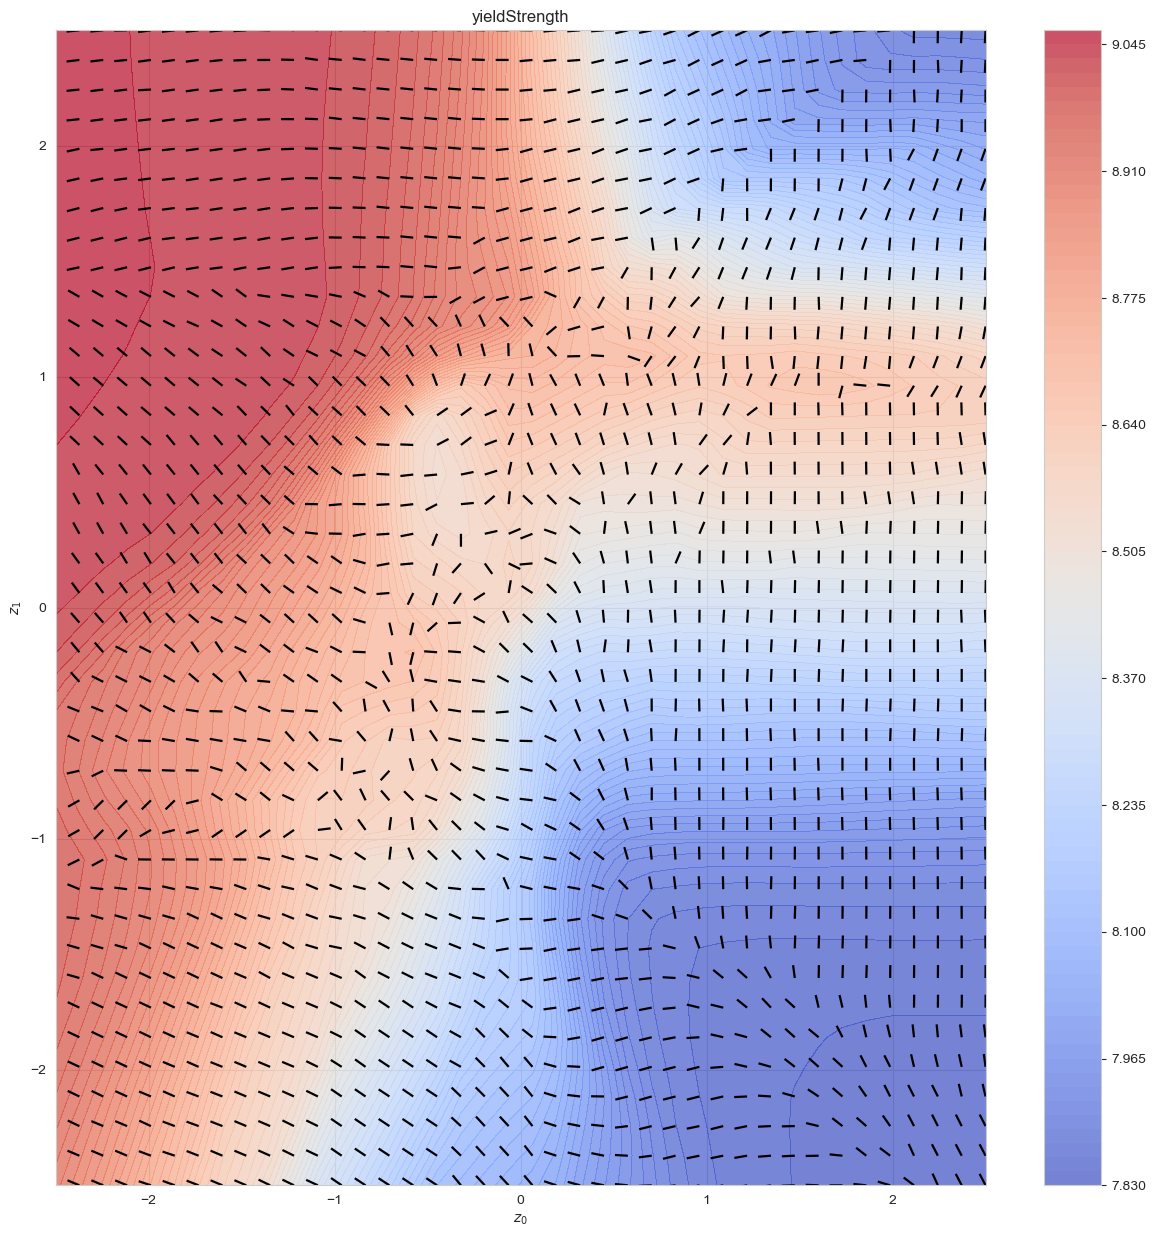

In [11]:
def plotLatentPropertyWithGradients(ltnt1 = 0, ltnt2 = 1):
  n = 40
  zmin, zmax = -2.5,2.5
  X,Y = np.meshgrid(np.linspace(zmin, zmax, n), np.linspace(zmin, zmax, n))
  Z = torch.zeros((n**2, vaeSettings['encoder']['latentDim']))
  Z[:,ltnt1], Z[:,ltnt2] = to_torch(X.reshape(-1)), to_torch(Y.reshape(-1))
  Z = torch.tensor(Z, requires_grad = True)
  vae = materialEncoder.vaeNet
  decodedVals = vae.decoder(Z)



  fig, ax = plt.subplots(1,1)
  #-------------------------------------------#
  props = ['youngsModulus','costPerKg','massDensity','yieldStrength']
  props = ['yieldStrength']
  for ctr, p in enumerate(props):
    idx = materialEncoder.dataInfo[p]['idx']
    scaleMax = materialEncoder.dataInfo[p]['scaleMax']
    scaleMin = materialEncoder.dataInfo[p]['scaleMin']

    matVal_decoded = 10.**(scaleMin + decodedVals[:,idx]*(scaleMax - scaleMin))

    dE_dz = to_np(torch.autograd.grad(matVal_decoded, Z, grad_outputs = torch.ones(Z.shape[0]), create_graph = True)[0])
    U = dE_dz[:,0] / (1e-4+np.sqrt(dE_dz[:,0]**2 + dE_dz[:,1]**2))
    V = dE_dz[:,1] / (1e-4+np.sqrt(dE_dz[:,0]**2 + dE_dz[:,1]**2))
    plt.subplot(1,1,ctr+1)
    surf = plt.contourf(X, Y, np.log10(to_np(matVal_decoded).reshape((n,n))), levels = 100, cmap='coolwarm', alpha = 0.7)
    plt.quiver(X,Y,U,V, headwidth = 0, headlength = 0,headaxislength = 0, color = 'black')
#     plt.clabel(surf, inline=False, fontsize=12, fmt ='%0.2F', colors = 'black')
    plt.title(p)
    plt.xlabel('$z_0$')
    plt.ylabel('$z_1$')
    cbar = plt.colorbar(surf)
#     cbar.set_label('$log_{10}$({:s})'.format(p))
  
  plt.savefig('./figures/latentSpaceGradient.pdf'.format(p), dpi=200, bbox_inches='tight')
  
plotLatentPropertyWithGradients()